In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train.shape, test.shape, submission.shape

((45532, 77), (11383, 76), (11383, 1))

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## 컬럼 분류

In [5]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


## CovariateShift

In [6]:
train['race']=pd.factorize(train['race'])[0]
test['race']=pd.factorize(test['race'])[0]

train = pd.get_dummies(train, columns=['race'])
test = pd.get_dummies(test, columns=['race'])

train.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)
test.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)


train.drop('religion', axis=1, inplace=True)
test.drop('religion', axis=1, inplace=True)

### Q_A

In [7]:
Q_A = meta[meta.gbn=='Q_A'].index

train[Q_A].describe()
train[Q_A].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,2.904463,3.662347,1.749078,2.317952,2.168145,2.560595,2.317952,3.157691,3.575529,3.813933,4.325727,3.509620,2.632896,3.217232,3.071752,2.840464,2.823487,3.432948,3.225687
std,1.196952,1.566142,1.431494,1.043625,1.369205,1.348653,1.510600,1.460813,1.481740,1.361220,1.372551,1.146992,1.375134,1.473022,1.476414,1.489744,1.404342,1.424383,1.374938,1.521603
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


<AxesSubplot:>

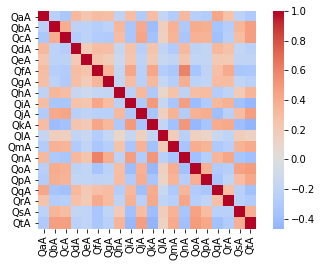

In [8]:
corr = train[Q_A].corr(method = 'spearman')
sns.heatmap(corr, cmap="coolwarm", square=True, center=0)

In [9]:
minus_cols = ["QeA", "QfA", "QkA", "QqA", "QrA","QaA", "QdA", "QgA", "QiA", "QnA"]
for f in minus_cols: 
    train[f] = train[f]*-1
    test[f] = test[f]*-1
train.head(3)    

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13,race_0
index,,,,,,,,,,,,,,,,,,,,,
0,-3.0,363,4.0,1370,5.0,997,-1.0,1024,-2.0,1577,...,1,0,1,1,0,1,0,1,1,1
1,-5.0,647,5.0,1313,3.0,3387,-5.0,2969,-1.0,4320,...,1,0,1,1,0,1,0,1,1,0
2,-4.0,1623,1.0,1480,1.0,1021,-4.0,3374,-5.0,1333,...,1,0,1,1,1,1,0,1,1,1


In [10]:
train['Mach_score'] = train[Q_A].mean(axis = 1)
test['Mach_score'] = test[Q_A].mean(axis = 1)

### Q_A 1/5 count

In [ ]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q_A15'] = 0
train['Q_A3'] = 0

test['Q_A15'] = 0
test['Q_A3'] = 0

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1
        elif v == 3:
            train.loc[i, 'Q_A3'] = train.loc[i, 'Q_A3']+1
        elif v == 5:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1            

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1
        elif v == 3:
            test.loc[i, 'Q_A3'] = test.loc[i, 'Q_A3']+1            
        elif v == 5:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1                        

### Q_E

In [ ]:
Q_E = meta[meta.gbn == 'Q_E'].index

train[Q_E].describe()
train[Q_E].head()

In [ ]:
train[Q_E]

### tp

In [11]:
# 0~7 
tp = meta[meta.gbn=='tp'].index

train[tp].describe()
train[tp].head(3)

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,3.017241,2.621189,1.768712,3.041246,1.335918,2.472217,2.031099,3.507226,2.277497,4.317996
std,2.007713,1.897081,1.685069,2.037278,1.452544,2.000658,1.785824,1.971456,1.848783,1.722793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000
50%,3.000000,2.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000
75%,5.000000,4.000000,3.000000,5.000000,2.000000,4.000000,3.000000,5.000000,4.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,2,2,1,2,1,7,4,4,3
1,1,1,0,0,1,2,3,4,0,4
2,2,3,1,5,3,4,2,6,1,3


In [12]:
minus_cols = ["tp02", "tp04", "tp06", "tp08", "tp10"]

for f in minus_cols: 
    train[f] = train[f]*-1
    test[f] = test[f]*-1
train[tp].head(3)    

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,-2,2,-1,2,-1,7,-4,4,-3
1,1,-1,0,0,1,-2,3,-4,0,-4
2,2,-3,1,-5,3,-4,2,-6,1,-3


In [13]:
train['Extraversion'] = train[['tp01','tp06']].mean(axis = 1)
train['Agreeableness'] = train[['tp02','tp07']].mean(axis = 1)
train['Conscientiousness'] = train[['tp03','tp08']].mean(axis = 1)
train['EmotionalStability'] = train[['tp04','tp09']].mean(axis = 1)
train['OpennesstoExperience'] = train[['tp05','tp10']].mean(axis = 1)

test['Extraversion'] = test[['tp01','tp06']].mean(axis = 1)
test['Agreeableness'] = test[['tp02','tp07']].mean(axis = 1)
test['Conscientiousness'] = test[['tp03','tp08']].mean(axis = 1)
test['EmotionalStability'] = test[['tp04','tp09']].mean(axis = 1)
test['OpennesstoExperience'] = test[['tp05','tp10']].mean(axis = 1)

In [ ]:
# tp: 1,7 극단값 선택한 count 추출, 4 중간값 선택 count 
train['tp17'] = 0
train['tp4'] = 0

test['tp17'] = 0
test['tp4'] = 0

In [ ]:
%%time
for f in tp:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 7:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 4:
            train.loc[i, 'tp4'] = train.loc[i, 'tp4']+1            

In [ ]:
%%time
for f in tp:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 7:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 4:
            test.loc[i, 'tp4'] = test.loc[i, 'tp4']+1            

#### 극단값 중간값

In [ ]:
train['Q_A15tp17'] = train['Q_A15'] + train['tp17']
train['Q_A3tp4'] = train['Q_A3'] + train['tp4']

In [ ]:
test['Q_A15tp17'] = test['Q_A15'] + test['tp17']
test['Q_A3tp4'] = test['Q_A3'] + test['tp4']

In [ ]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

In [ ]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

## Target Encoding

### age_group

In [14]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [15]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [16]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [17]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [18]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [19]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

### outlier

In [20]:
train = train[train.familysize < 25]

In [ ]:
train.shape, train.columns

In [ ]:
test.shape, test.columns

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

#col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat = [
 'QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
#'race_0',
 #'religion',
 'urban'
#,'Priority'
          ]

In [22]:
ignore_cols = meta[(meta.gbn=='Q_A')|(meta.gbn=='tp')].index
ignore_cols

Index(['QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA',
       'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA',
       'tp01', 'tp02', 'tp03', 'tp04', 'tp05', 'tp06', 'tp07', 'tp08', 'tp09',
       'tp10'],
      dtype='object', name='col')

In [24]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'voted'
          #, categorical_features=col_cat
          , numeric_features = ['race_0']#,,'tp17','tp4','Q_A15','Q_A3','Q_A15tp17','Q_A3tp4']#['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
          , ignore_features =ignore_cols#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45524, 83)"
4,Missing Values,False
5,Numeric Features,49
6,Categorical Features,33
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 27.5 s


In [25]:
best_3 = compare_models(sort = 'AUC', n_select = 3
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6923,0.7644,0.6487,0.7543,0.6975,0.3880,0.3927,11.8833
1,CatBoost Classifier,0.6896,0.7619,0.6513,0.7485,0.6965,0.3820,0.3859,15.8860
2,Light Gradient Boosting Machine,0.6891,0.7615,0.6472,0.7500,0.6948,0.3814,0.3858,0.6966
3,Linear Discriminant Analysis,0.6858,0.7585,0.6477,0.7445,0.6927,0.3744,0.3782,0.2864
4,Ada Boost Classifier,0.6878,0.7545,0.6503,0.7462,0.6949,0.3783,0.3821,2.6704
5,Extra Trees Classifier,0.6867,0.7531,0.6537,0.7426,0.6953,0.3756,0.3789,1.2750
6,Extreme Gradient Boosting,0.6715,0.7408,0.6631,0.7153,0.6882,0.3421,0.3432,4.3539
7,Random Forest Classifier,0.6545,0.7132,0.5951,0.7240,0.6532,0.3155,0.3216,0.2367
8,Quadratic Discriminant Analysis,0.5581,0.6924,0.9820,0.5542,0.7085,0.0312,0.0822,0.0829
9,Decision Tree Classifier,0.6091,0.6060,0.6388,0.6436,0.6412,0.2118,0.2119,0.7214


In [26]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6934,0.7658,0.6508,0.7548,0.6989,0.3901,0.3945
1,0.6987,0.7695,0.6570,0.7597,0.7046,0.4005,0.4049
2,0.6918,0.7678,0.6470,0.7543,0.6965,0.3871,0.3918
3,0.6891,0.7577,0.6429,0.7524,0.6933,0.3820,0.3868
4,0.6942,0.7632,0.6523,0.7551,0.7000,0.3916,0.3960
Mean,0.6934,0.7648,0.6500,0.7553,0.6987,0.3903,0.3948
SD,0.0032,0.0041,0.0048,0.0024,0.0037,0.0061,0.0059


In [27]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.694,0.7617,0.6511,0.7556,0.6995,0.3914,0.3959


In [28]:
%%time
final_model = finalize_model(blended)

Wall time: 5min 28s


In [29]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [30]:
submission['voted'] = predictions['Score']

# 5. 제출

In [31]:
submission.to_csv('output/20201015-1.csv')

In [32]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6979,0.7735,0.6500,0.7625,0.7018,0.3996,0.4048
1,0.6831,0.7503,0.6459,0.7413,0.6903,0.3690,0.3727
2,0.6871,0.7622,0.6467,0.7472,0.6933,0.3774,0.3815
3,0.7100,0.7754,0.6607,0.7757,0.7136,0.4237,0.4293
4,0.6979,0.7767,0.6574,0.7580,0.7041,0.3987,0.4029
5,0.6835,0.7624,0.6418,0.7443,0.6893,0.3705,0.3747
6,0.6924,0.7624,0.6402,0.7597,0.6948,0.3892,0.3951
7,0.6852,0.7546,0.6538,0.7400,0.6943,0.3724,0.3754
8,0.6964,0.7724,0.6497,0.7601,0.7006,0.3965,0.4015
9,0.6897,0.7537,0.6407,0.7546,0.6930,0.3835,0.3888


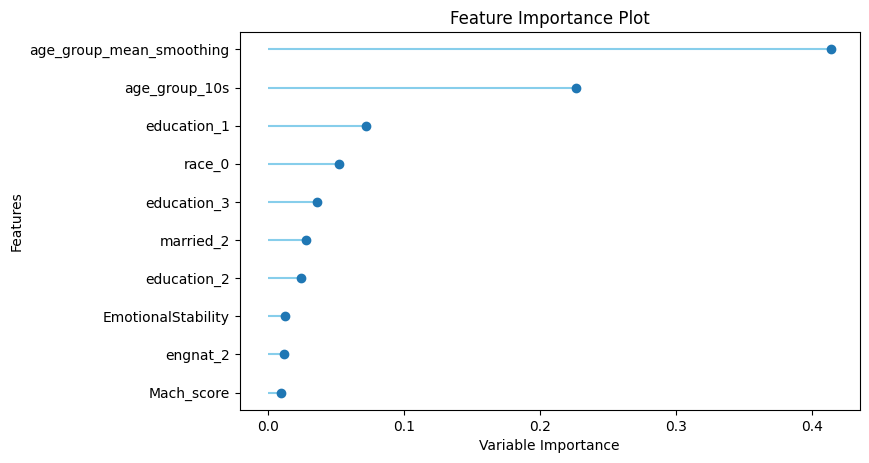

In [33]:
plot_model(estimator = gbc, plot = 'feature')

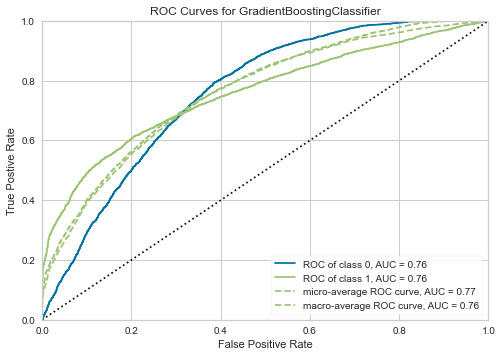

In [34]:
plot_model(estimator = gbc, plot = 'auc')

In [35]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6903,0.7671,0.6475,0.7517,0.6957,0.3839,0.3883
1,0.6831,0.7510,0.6451,0.7418,0.6900,0.3691,0.3729
2,0.6948,0.7610,0.6516,0.7564,0.7001,0.3928,0.3973
3,0.7060,0.7753,0.6656,0.7660,0.7123,0.4147,0.4189
4,0.7001,0.7730,0.6557,0.7626,0.7052,0.4036,0.4084
5,0.6835,0.7590,0.6393,0.7457,0.6884,0.3708,0.3753
6,0.6771,0.7523,0.6320,0.7399,0.6817,0.3582,0.3628
7,0.6798,0.7520,0.6456,0.7362,0.6879,0.3621,0.3654
8,0.6951,0.7723,0.6514,0.7569,0.7002,0.3935,0.3981
9,0.6812,0.7519,0.6382,0.7424,0.6864,0.3659,0.3702


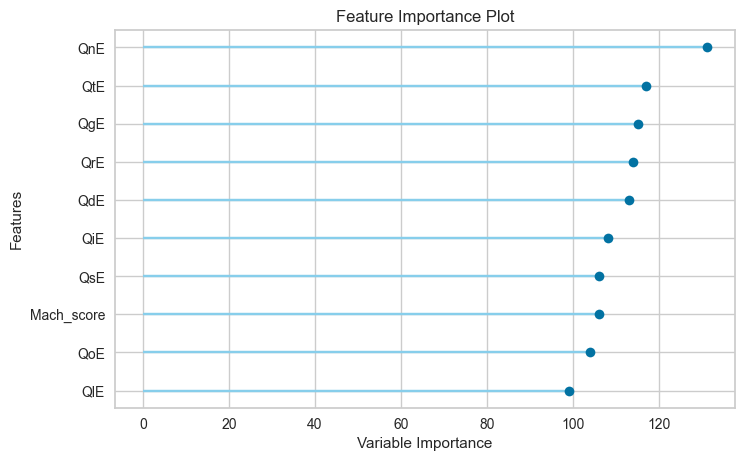

In [36]:
plot_model(estimator = lightgbm, plot = 'feature')